In [115]:
import os
current_directory = os.getcwd() # 현재 작업 디렉토리를 얻기
print("현재 작업 디렉토리:", current_directory)

현재 작업 디렉토리: c:\Users\jay_hook\myhub\miniproj


In [116]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)


- 데이터 불러오고 탐색하기

In [117]:
df = pd.read_csv("./scaled_data.csv", index_col=0)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, 0 to 215
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시점           216 non-null    int64  
 1   const        216 non-null    float64
 2   경제심리지수(원계열)  216 non-null    float64
 3   뉴스심리지수       216 non-null    float64
 4   원자재구입가격실적    216 non-null    float64
 5   달러결제수출비율     216 non-null    float64
 6   달러결제수입비율     216 non-null    float64
 7   달러결제순수입액     216 non-null    float64
 8   KO/US M2     216 non-null    float64
 9   BIRDIFF      216 non-null    float64
 10  TNDIFF       216 non-null    float64
 11  EIRDIFF      216 non-null    float64
 12  KRW/USD      216 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 23.6 KB


In [119]:
Mdate = df['시점']
df.drop(['시점'], axis=1, inplace=True)

In [120]:
df

,const,경제심리지수(원계열),뉴스심리지수,원자재구입가격실적,달러결제수출비율,달러결제수입비율,달러결제순수입액,KO/US M2,BIRDIFF,TNDIFF,EIRDIFF,KRW/USD
0,1.0,95.3,106.39,0.25,0.823,0.779,-3319.3,148.557565,-1.000,-0.292,1.5,1006.0
1,1.0,108.1,110.62,0.21,0.829,0.779,-2591.3,151.540035,-0.750,-0.503,1.7,1015.5
2,1.0,110.9,103.98,0.24,0.820,0.789,-1680.5,150.138301,-0.500,-0.289,1.5,997.1
3,1.0,110.4,100.87,0.26,0.825,0.786,-2170.7,151.788132,-0.500,-0.492,1.5,1007.7
4,1.0,103.8,101.94,0.16,0.826,0.798,-2202.8,152.821713,-0.250,-0.439,1.4,1025.4
...,...,...,...,...,...,...,...,...,...,...,...,...
211,1.0,99.3,97.92,0.32,0.860,0.836,6492.3,173.406803,-0.125,-0.129,1.1,1430.2
212,1.0,98.0,86.14,0.27,0.856,0.843,2502.6,174.518661,0.625,-0.068,0.7,1424.3
213,1.0,95.4,80.15,0.20,0.854,0.834,4600.8,176.261890,0.125,-0.219,0.9,1318.8
214,1.0,91.2,88.53,0.21,0.843,0.818,4468.2,177.473073,0.625,-0.310,0.8,1264.5


- 데이터 탐색 공분산성 확인

<Axes: >

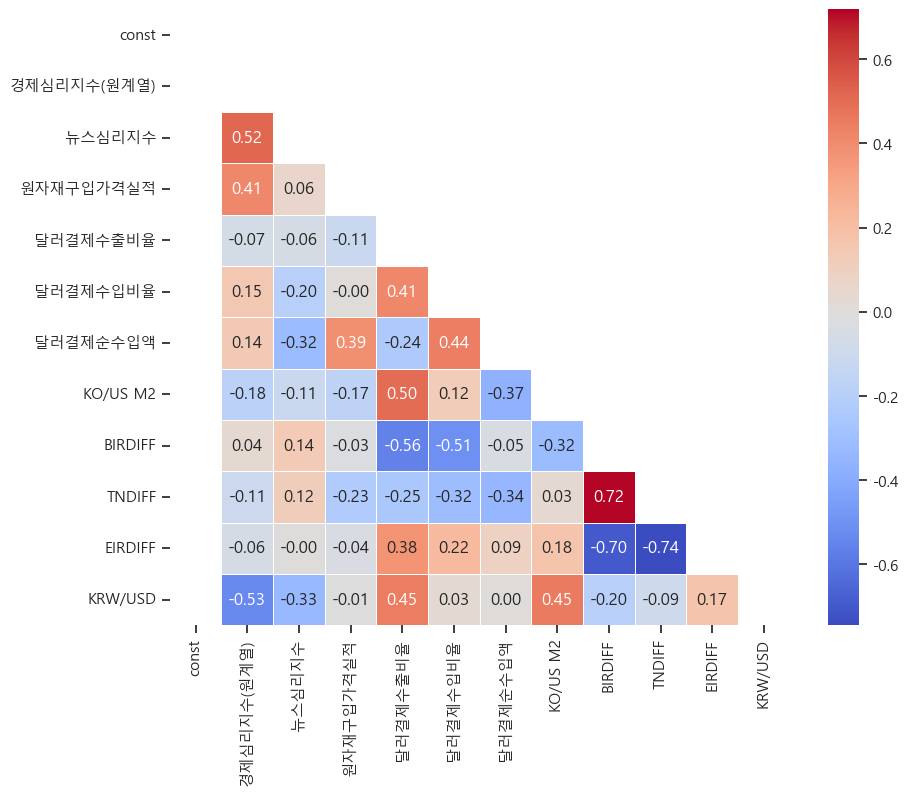

In [121]:
# 변수 다중공정성 보기  

corr_data = df[df.columns].corr()
plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_data, dtype=bool))

sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', mask=mask)

- 종속변수 인과관계 확인하기 

In [122]:
# 종속변수 인과관계 확인하기 
np.abs(corr_data.corr()['KRW/USD']).sort_values(ascending=False)

KRW/USD        1.000000
경제심리지수(원계열)    0.848150
KO/US M2       0.720856
뉴스심리지수         0.683621
달러결제수출비율       0.662070
BIRDIFF        0.460569
EIRDIFF        0.393812
원자재구입가격실적      0.318152
TNDIFF         0.249831
달러결제수입비율       0.193349
달러결제순수입액       0.139025
const               NaN
Name: KRW/USD, dtype: float64

In [123]:
df.columns

Index(['const', '경제심리지수(원계열)', '뉴스심리지수', '원자재구입가격실적', '달러결제수출비율', '달러결제수입비율',
       '달러결제순수입액', 'KO/US M2', 'BIRDIFF', 'TNDIFF', 'EIRDIFF', 'KRW/USD'],
      dtype='object')

- VIF 확인하기 

In [124]:
# VIF 확인하기 
X = df.drop(['KRW/USD'], axis=1)
# statsmodels의 상수항을 추가하기 위해 X에 상수 열 추가
X = sm.add_constant(X)

# VIF 계산
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 결과 출력
vif.sort_values('VIF Factor',ascending=False)

,Feature,VIF Factor
0,const,7459.483119
8,BIRDIFF,4.632962
9,TNDIFF,4.333911
6,달러결제순수입액,3.370857
10,EIRDIFF,3.267152
5,달러결제수입비율,3.115345
4,달러결제수출비율,2.206468
1,경제심리지수(원계열),2.094464
2,뉴스심리지수,1.997206
3,원자재구입가격실적,1.734415


- OLS 정보 보기

In [125]:
# OLS 정보 보기 
# X = df[['위안화원_시', '유로달러_시', 'WTI','달러위안화_시','콜금리','달러엔_시']]
y = df[['KRW/USD']]
feature_add = sm.add_constant(X, has_constant='add')
# sm OLS 적합
model = sm.OLS(y , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                KRW/USD   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     36.53
Date:                Tue, 10 Oct 2023   Prob (F-statistic):           2.46e-40
Time:                        22:17:37   Log-Likelihood:                -1201.2
No. Observations:                 216   AIC:                             2424.
Df Residuals:                     205   BIC:                             2461.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -748.6108    189.793     -3.944      0.000   -1122.808    -374.414
const        -748.6108    189.793     -3.944      0.000   -1122.808    -374.414
경제심리지수(원계열)    -6.0583      0.613     -9.886      0.000      -7.267      -4.850
뉴스심리지수          1.2021      0.623      1.931      0.055      -0.025       2.430
원자재구입가격실적     124.5887     42.452      2.935      0.004      40.890     208.287
달러결제수출비율     4194.0332    489.379      8.570      0.000    3229.172    5158.894
달러결제수입비율    -1277.1413    363.082     -3.518      0.001   -1992.994    -561.288
달러결제순수입액        0.0129      0.002      5.334      0.000       0.008       0.018
KO/US M2        3.6229      0.538      6.734      0.000       2.562       4.684
BIRDIFF        10.3844      7.296      1.423      0.156      -4.001      24.770
TNDIFF        -17.1681     11.691     -1.468      0.144     -40.219       5.883
EIRDIFF        -5.2145      3.731     -1.398      0.164     -12.570       2.141
==============================================================================
Omnibus:                        9.597   Durbin-Watson:                   0.722
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.942
Skew:                           0.214   Prob(JB):                     0.000345
Kurtosis:                       4.260   Cond. No.                     4.51e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.84e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- 변수 좁히기

In [126]:
fitted_model.rsquared

0.6405629560486434

In [127]:
X = X[fitted_model.pvalues.index[fitted_model.pvalues < 0.05].drop('const')]

<Axes: >

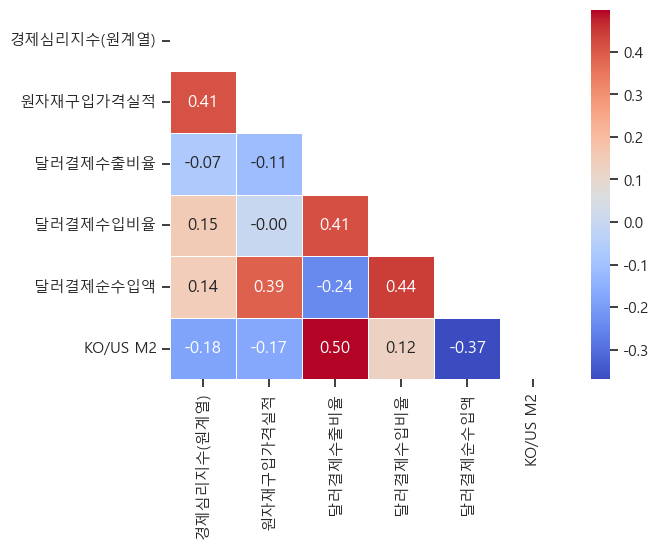

In [128]:
# 상관계수 표
corr_data = X[X.columns].corr()
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', mask=mask)

In [129]:
y.values.ravel()

array([1006. , 1015.5,  997.1, 1007.7, 1025.4, 1026.8, 1038.5, 1041.1,
       1040.2, 1033.5, 1011.6,  964.6,  970.9,  971.6,  943.4,  945.6,
        948.9,  955.2,  961.5,  946.2,  942.3,  929.5,  929.8,  941. ,
        941.8,  940.9,  930.8,  927.7,  923.8,  919.3,  938.3,  915.1,
        900.7,  921.1,  936.1,  943.9,  939. ,  990.4, 1002.6, 1030.1,
       1046. , 1012.2, 1089. , 1207. , 1291. , 1469. , 1259.5, 1379.5,
       1534. , 1383.5, 1282. , 1255. , 1273.9, 1228.5, 1248.9, 1178.1,
       1182.5, 1162.8, 1164.5, 1161.8, 1160. , 1131.3, 1108.4, 1202.5,
       1222.2, 1182.7, 1198.1, 1140.2, 1125.3, 1159.7, 1134.8, 1121.5,
       1128.7, 1096.7, 1071.5, 1079.2, 1067.7, 1054.5, 1066.8, 1178.1,
       1110. , 1143. , 1151.8, 1123.3, 1118.7, 1133. , 1130. , 1180.3,
       1145.4, 1130.6, 1134.7, 1111.4, 1090.7, 1082.9, 1070.6, 1089. ,
       1083. , 1111.1, 1101.2, 1129.7, 1142. , 1123.5, 1110. , 1074.7,
       1060.7, 1058.2, 1055.4, 1070.4, 1067.5, 1064.7, 1033.2, 1020.1,
      

- 종속변수와 산점도

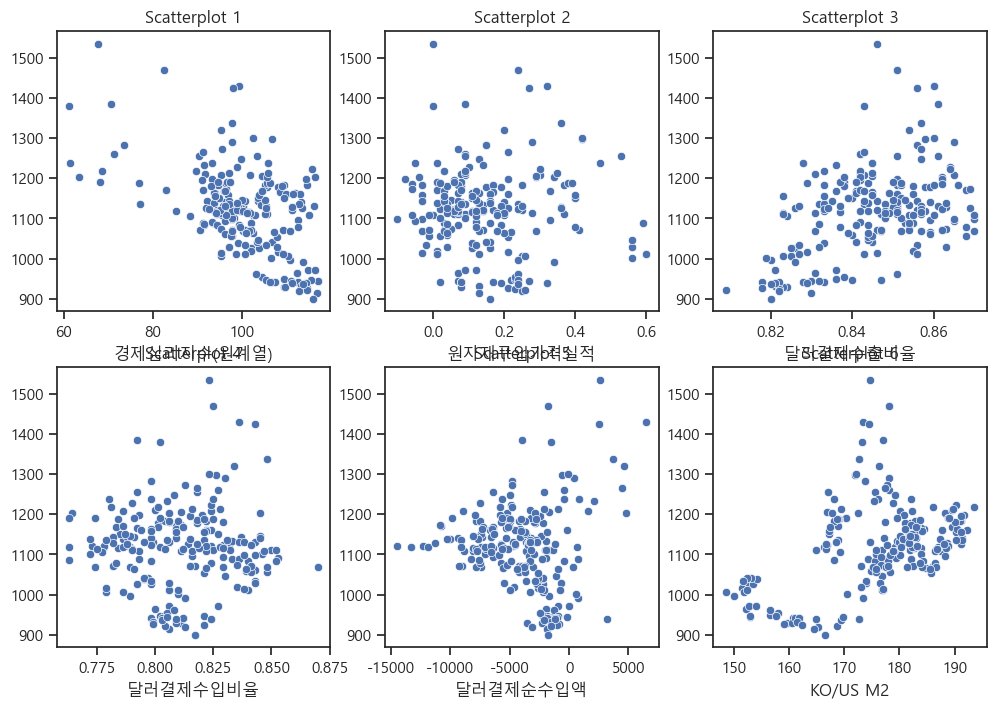

In [130]:
# 2x3 서브플롯 생성
ncols = 3
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 8))
df1 = X

# 각 열에 대한 산점도 그리기
for i in range(nrows):
    for j in range(ncols):
        num = i * ncols + j
        sns.scatterplot(x=df1[df1.columns[num]], y=y.values.ravel(), ax=axs[i][j])
        axs[i][j].set_title(f"Scatterplot {num+1}")

- 독립변수끼리 산점도

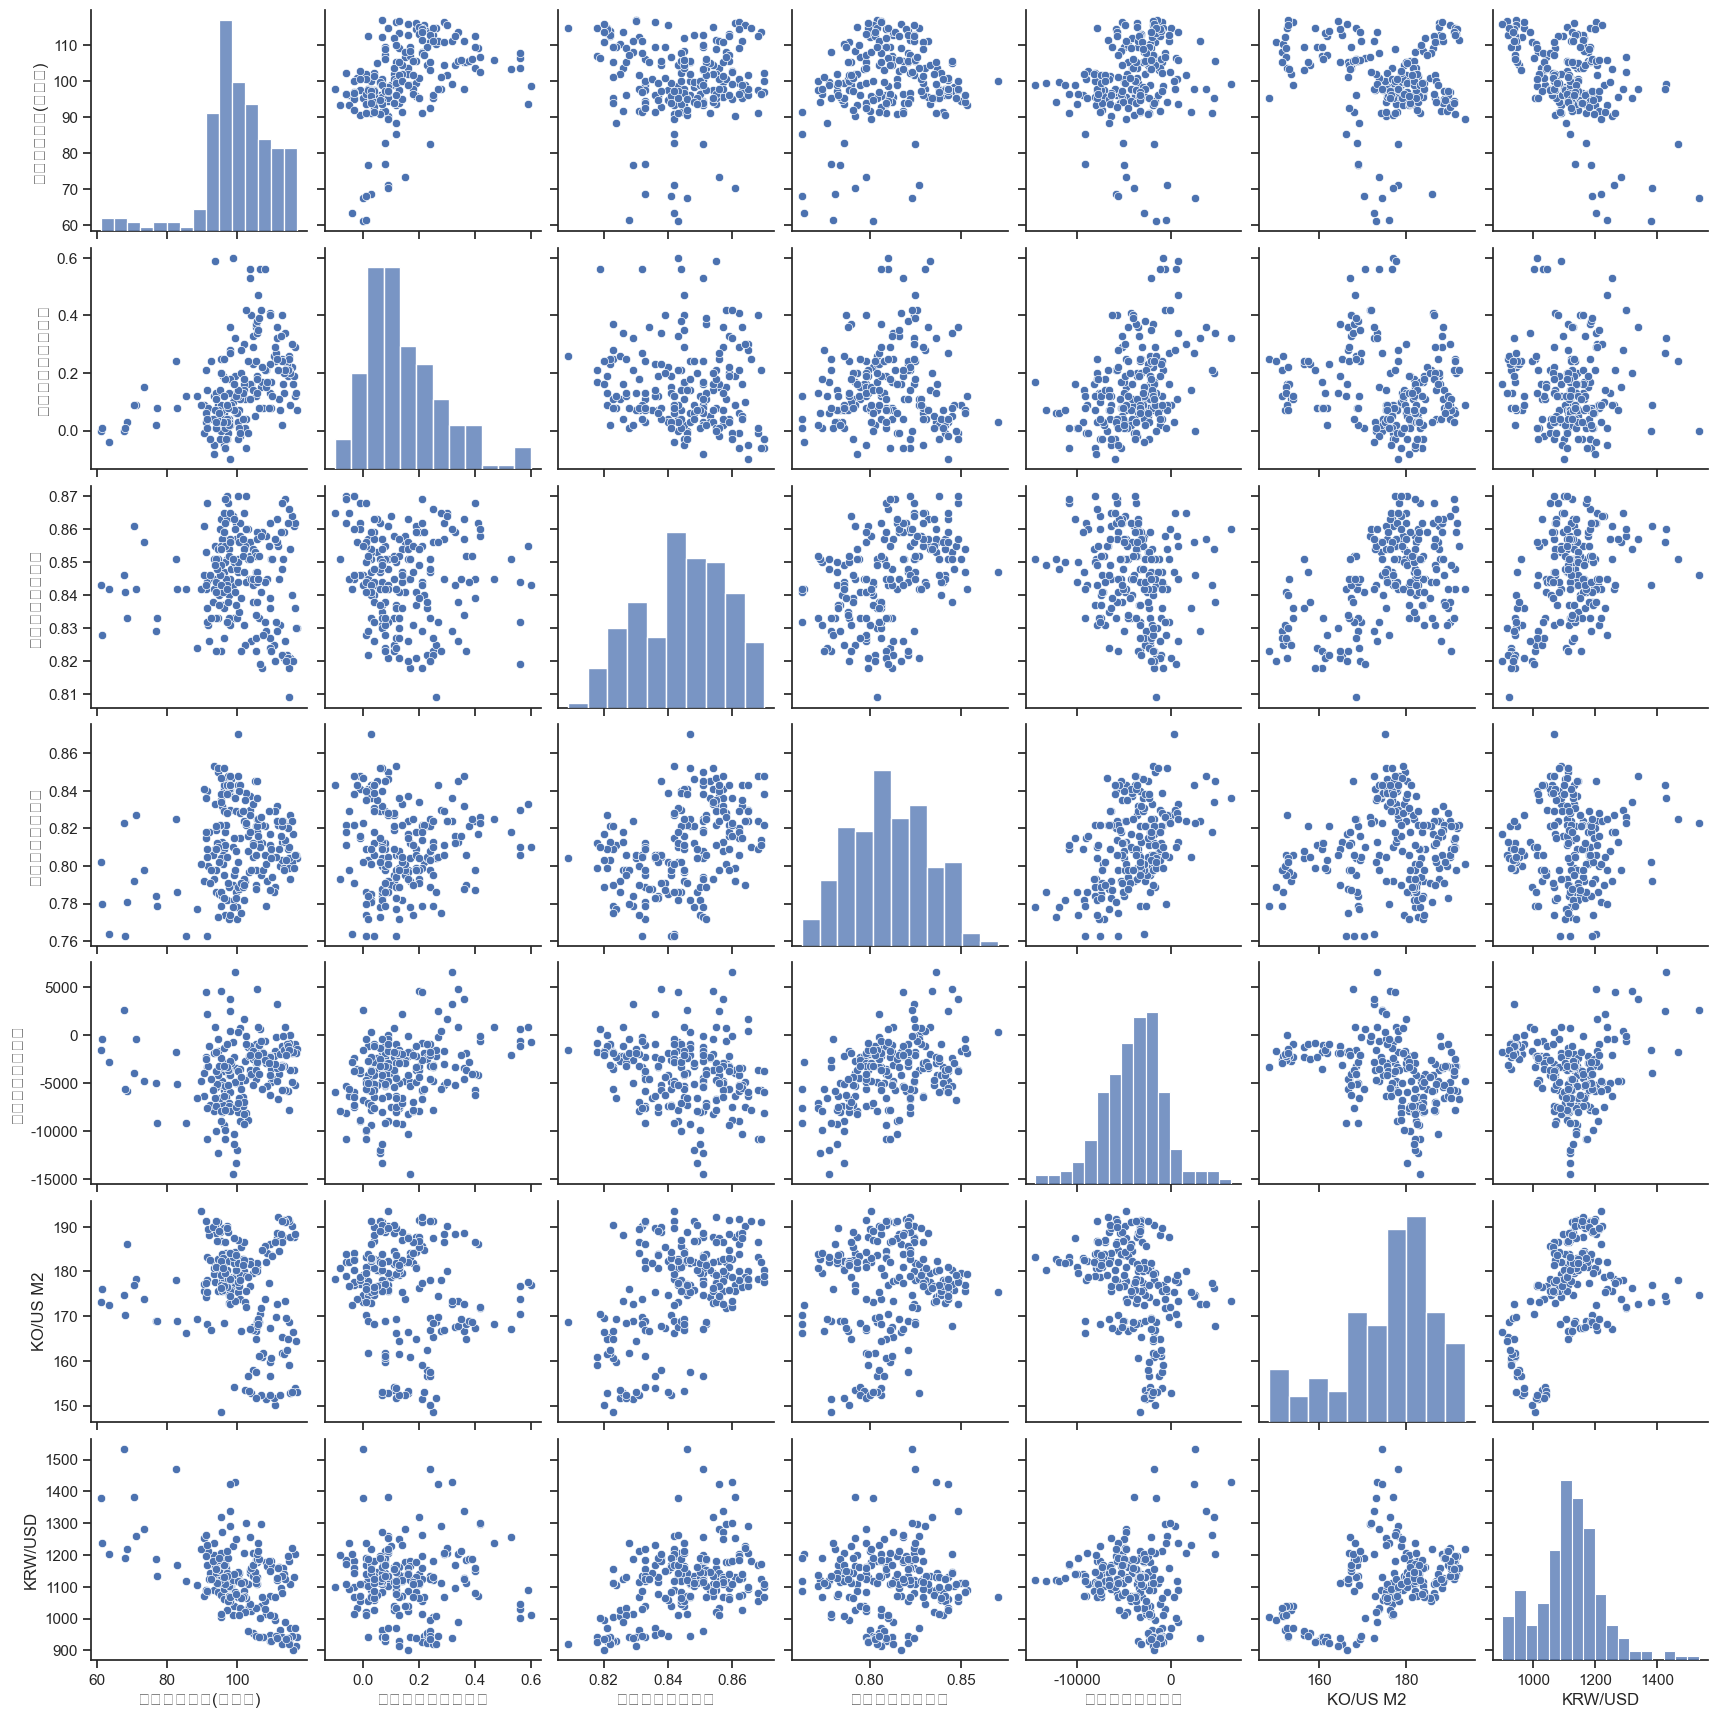

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# X는 독립 변수, y는 종속 변수로 설정해야 합니다.
# X = df[['경제심리지수(원계열)', '뉴스심리지수', '소비자심리지수', '원자재구입가격실적', '수출실적', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액', 'KO/US M2', 'BIRDIFF', 'TNDIFF']]
y = df['KRW/USD']

# 플롯을 그립니다.
sns.set(style="ticks")
sns.pairplot(pd.concat([X, y], axis=1))
plt.show()

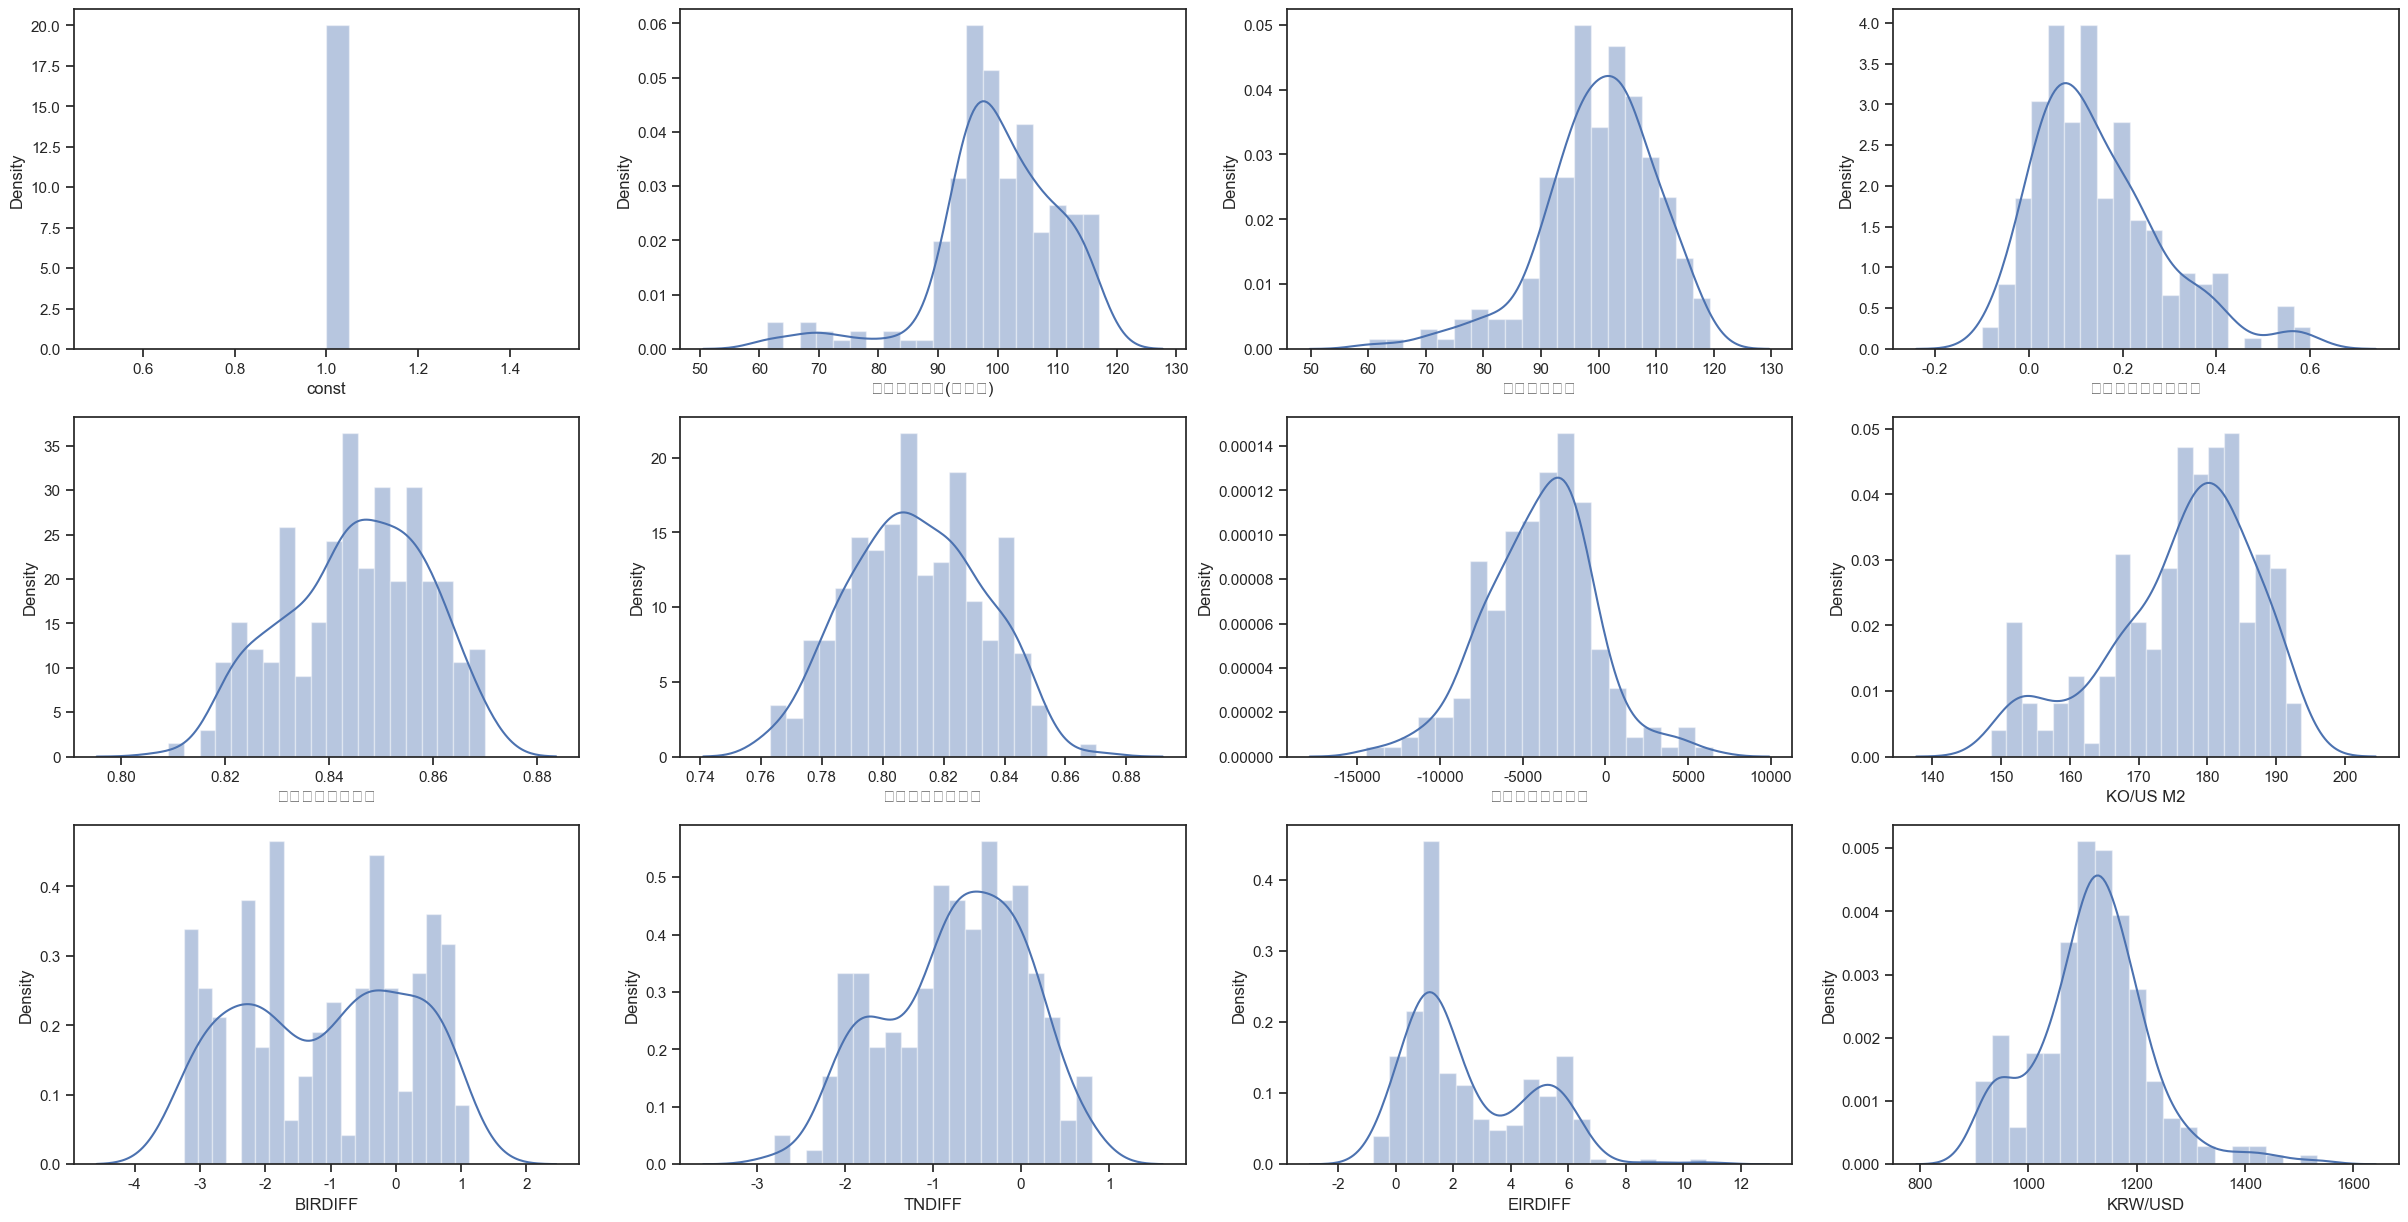

In [132]:
## histogram
col_n = 4
row_n = 3

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(30,row_n*5))

for i,col in enumerate(df.columns):
    sns.distplot(df[col], bins=20, ax=ax[int(i/col_n),int(i%col_n)])

- train_test_split

In [133]:
## 독립변수 선택 복습 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# df=pd.read_csv('../해커톤/Woo_data_3.csv',encoding='euc-kr',index_col=0)
# X=df.drop(['달러원종가','달러원시가'], axis=1)
# y=df[['달러원종가']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False,random_state=42)

# RFE (Recursive Feature Elimination)

In [134]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
model = LinearRegression()

RFE = RFE(model, n_features_to_select=5) # 변수를 5개 선택
X_train_RFE = RFE.fit_transform(X_train,y_train)
X_test_RFE = RFE.transform(X_test)

In [135]:
X_train_RFE

array([[ 9.53000000e+01,  2.50000000e-01,  8.23000000e-01,
         7.79000000e-01,  1.48557565e+02],
       [ 1.08100000e+02,  2.10000000e-01,  8.29000000e-01,
         7.79000000e-01,  1.51540035e+02],
       [ 1.10900000e+02,  2.40000000e-01,  8.20000000e-01,
         7.89000000e-01,  1.50138301e+02],
       [ 1.10400000e+02,  2.60000000e-01,  8.25000000e-01,
         7.86000000e-01,  1.51788132e+02],
       [ 1.03800000e+02,  1.60000000e-01,  8.26000000e-01,
         7.98000000e-01,  1.52821713e+02],
       [ 1.02100000e+02,  1.10000000e-01,  8.25000000e-01,
         7.92000000e-01,  1.53535950e+02],
       [ 9.91000000e+01,  1.10000000e-01,  8.33000000e-01,
         7.95000000e-01,  1.54163214e+02],
       [ 1.03300000e+02,  1.60000000e-01,  8.45000000e-01,
         7.97000000e-01,  1.53173760e+02],
       [ 1.06700000e+02,  1.50000000e-01,  8.41000000e-01,
         7.95000000e-01,  1.52418583e+02],
       [ 1.05400000e+02,  1.20000000e-01,  8.27000000e-01,
         7.98000000e-01

In [136]:
# feature 개수
RFE.n_features_in_

6

In [137]:
# feature들
RFE.feature_names_in_

array(['경제심리지수(원계열)', '원자재구입가격실적', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액',
       'KO/US M2'], dtype=object)

In [138]:
# 우선순위
RFE.ranking_

array([1, 1, 1, 1, 2, 1])

In [139]:
# 우선순위가 1인 feature들
RFE.ranking_ ==1

array([ True,  True,  True,  True, False,  True])

In [140]:
# 우선순위가 1인 feature들 선택
RFE.feature_names_in_[RFE.ranking_ ==1]   

array(['경제심리지수(원계열)', '원자재구입가격실적', '달러결제수출비율', '달러결제수입비율', 'KO/US M2'],
      dtype=object)

# f_regression과 SelectKBest

In [141]:
## Filter 
from sklearn.feature_selection import f_regression, SelectKBest
## selctor 정의하기.
selector = SelectKBest(score_func=f_regression, k=4)
## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)
## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((172, 4), (44, 4))

In [142]:
selector.feature_names_in_

array(['경제심리지수(원계열)', '원자재구입가격실적', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액',
       'KO/US M2'], dtype=object)

In [143]:
selector.get_support()

array([ True, False,  True, False,  True,  True])

In [144]:
selected_mask =selector.get_support()
selected_names = X.columns[selected_mask]
unselected_names = X.columns[~selected_mask]

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['경제심리지수(원계열)', '달러결제수출비율', '달러결제순수입액', 'KO/US M2'], dtype='object')
Unselected names:  Index(['원자재구입가격실적', '달러결제수입비율'], dtype='object')


In [145]:
## Embedded
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=RandomForestRegressor(), threshold=0.1).fit(X_train, y_train)
rf = selector.get_support()
count = np.count_nonzero(rf)
count


2

In [146]:
selector.get_support()

array([ True, False, False, False, False,  True])

In [147]:
selected_mask2=selector.get_support()

In [148]:
selected_names = X.columns[selected_mask2]
unselected_names = X.columns[~selected_mask2]

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['경제심리지수(원계열)', 'KO/US M2'], dtype='object')
Unselected names:  Index(['원자재구입가격실적', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액'], dtype='object')


In [149]:
# Ridge 해보기 

# X = df[['위안화원_시', '유로달러_시', 'WTI','달러위안화_시','달러엔_시','콜금리']]
# y= df[['달러원종가']]

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 파이프라인 생성
pipeline = Pipeline([
    ('mm_scaler', MinMaxScaler()),  # 표준화
    ('ridge_reg', Ridge(alpha=1, solver="cholesky"))  # Ridge 회귀 모델
])

# 파이프라인 학습
pipeline.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = pipeline.predict(X_test) 
# 모델이 있어서 predict 한것 
# 스켈링만 있으면 trasform 한것 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
score = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r2_score: {score:.2f}')



Mean Squared Error: 3508.67
Root Mean Squared Error: 59.23
r2_score: 0.58


In [150]:
from sklearn.model_selection import train_test_split

# X = df[['유로달러_시', 'WTI','달러위안화_시','달러엔_시','콜금리']]
# y= df[['달러원종가']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False,random_state=42) 


In [158]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

sclaer = MinMaxScaler()
lgb=LGBMRegressor()

pipe = Pipeline([
    ('scaler',sclaer),
    ('model', lgb)
])

param = {
    'model__max_depth': [1, 2,3,5],
    'model__learning_rate' : [0.1,0.01, 0.001]
}

grid = GridSearchCV(estimator=pipe, param_grid=param, cv=3)
grid.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 6
[LightGBM] [Info] Start training from score 1118.637713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 6
[LightGBM] [Info] Start training from score 1090.799128
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 6
[LightGBM] [Info] Start training 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', LGBMRegressor())]),
             param_grid={'model__learning_rate': [0.1, 0.01, 0.001],
                         'model__max_depth': [1, 2, 3, 5]})

In [159]:
grid.best_params_

{'model__learning_rate': 0.01, 'model__max_depth': 2}

In [160]:
y_pred=grid.predict(X_test)

In [161]:
y_pred

array([1153.97253616, 1121.5657772 , 1153.97253616, 1154.36119288,
       1154.36119288, 1153.97253616, 1153.97253616, 1121.5657772 ,
       1121.54641823, 1154.36119288, 1153.97253616, 1153.97253616,
       1043.06528541, 1033.26281998, 1032.87416326, 1033.26281998,
       1032.87416326, 1032.87416326, 1032.87416326, 1033.26281998,
       1032.87416326, 1032.87416326, 1032.87416326, 1032.87416326,
       1032.87416326, 1032.30828018, 1033.26281998, 1033.26281998,
       1033.26281998, 1033.26281998, 1033.26281998, 1019.0775672 ,
       1018.68891049, 1033.26281998, 1033.26281998, 1019.0775672 ,
       1024.57090322, 1024.57090322, 1024.16288753, 1098.54242836,
       1098.54242836, 1098.54242836, 1154.36119288, 1153.97253616])

In [162]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
score = r2_score(y_pred,y_test)


print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r2_score:{score:.2f}')

Mean Squared Error: 23740.31
Root Mean Squared Error: 154.08
r2_score:-7.03


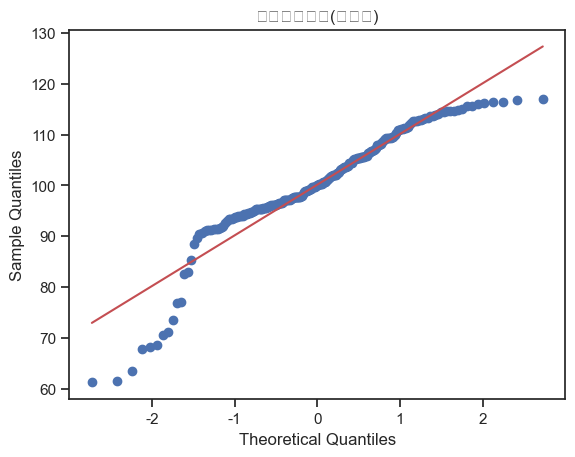

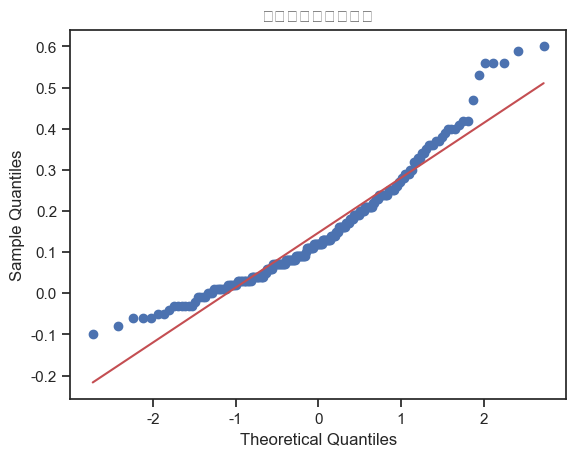

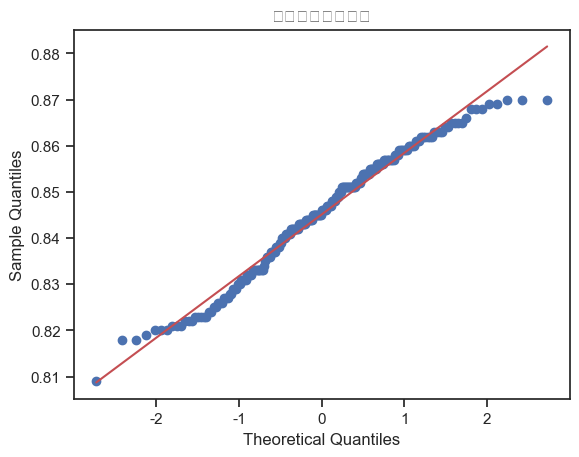

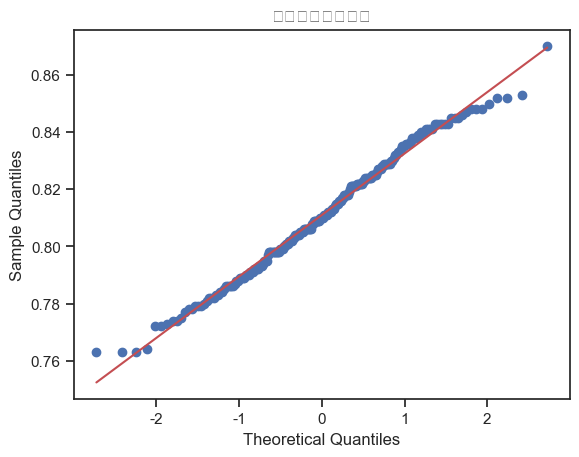

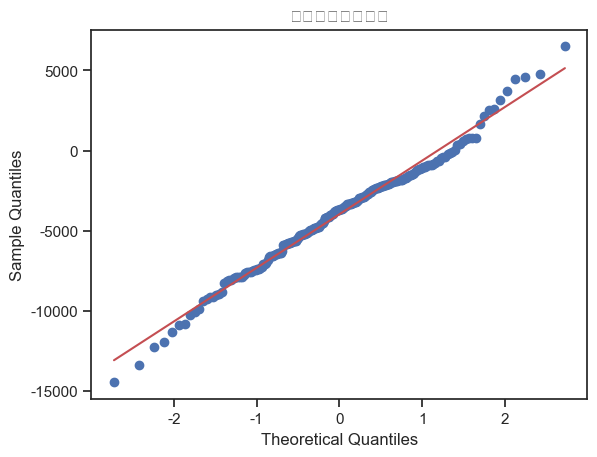

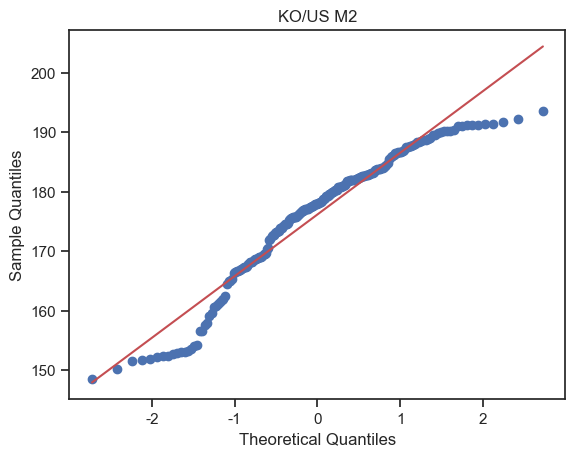

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 샘플 데이터 생성 (정규 분포를 따르지 않는 예제)
# np.random.seed(123)
# data = np.random.poisson(lam=2, size=100)  # 포아송 분포를 따르는 데이터 생성

# Q-Q plot 그리기
for i in range(len(X.columns)):
    stats.probplot(X[X.columns[i]], dist="norm", plot=plt)
    plt.title(X.columns[i])
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

In [157]:
X.columns

Index(['경제심리지수(원계열)', '원자재구입가격실적', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액',
       'KO/US M2'],
      dtype='object')